# Plotting resampled figures and calculating spatial consistency

### Author: Chris Wyburn-Powell, [github](https://github.com/chrisrwp/synthetic-ensemble/SIC/Resampled_figures_SIC.ipynb)

**Input**: <br>
- Resampled models and observations. 4 different methods being compared:
    * Individual linear detrending, without adjustment to physical bounds
    * Individual linear detrending, with adjustment
    * Ensemble linear detrending, with adjustment
    * 2 year filtering, without adjustment

**Output**: <br>
- Figures of ratio and difference between the three measures of variability **$\sigma_{LE}$**,  **$\sigma_{mem}$**, **$\sigma_{obs}$**
- Consistency figure of all 6 models with NSIDC CDR and HadISST1, alongside consistency agreement and disagreement between the observational datasets

In [1]:
import numpy as np
import xarray as xr
import datetime
import math as m
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.path as mpath
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.patheffects as pe
import cartopy.crs as ccrs

print(datetime.datetime.utcnow().strftime("%H:%M UTC %a %Y-%m-%d"))

21:37 UTC Tue 2022-04-19


In [2]:
data_path = '/glade/campaign/univ/ucub0084/Synthetic_ensemble/'

model_names  = ['CanESM2', 'CESM1', 'CSIRO_MK36', 'GFDL_CM3', 'GFDL_ESM2M', 'MPI_ESM1']
model_print_names  = ['CanESM2', 'CESM1', 'CSIRO MK3.6', 'GFDL CM3', 'GFDL ESM2M', 'MPI ESM1' ]
dataset_names = ['HadISST1', 'Merged_Hadley_OI', 'NSIDC_BT', 'NSIDC_CDR', 'NSIDC_NT']

dataset_print_names = ['HadISST1', 'BT', 'CDR', 'NT']

label_letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i' , 'j', 'k', 'l']

# Make land masks

In [3]:
#quickly make mask from regridded 30N areacello files. Land = np.nan, ocean = 0
masks = {}
masks_NSIDC = {}

NSIDC_sample = xr.open_dataset(data_path+'Raw_data/observations/NSIDC_CDR_v4/seaice_conc_monthly_nh_202003_f17_v04r00_regrid.nc')

for model_name in model_names:
    if model_name == 'GFDL_CM3':
        GFDL_CM3_SIC_regrid = xr.open_dataset(data_path+'Raw_data/areacello/GFDL_CM3/GFDL_CM3_1979_03_mem1_regrid.nc')
        mask_temp = GFDL_CM3_SIC_regrid['sic'].where(GFDL_CM3_SIC_regrid['sic']>0,-999)
    else:
        areacello_regrid = xr.open_dataset(data_path+'Raw_data/areacello/areacello_{}_30N_regrid.nc'.format(model_name))
        mask_temp = areacello_regrid['areacello'].where(areacello_regrid['areacello']>0,-999)
        
    mask_temp = mask_temp.where(mask_temp==-999,0)
    masks[model_name] = mask_temp.where(mask_temp==0)
    
    masks_NSIDC[model_name] = mask_temp.where(mask_temp==0).where(NSIDC_sample['cdr_seaice_conc_monthly'][0]>-1)
    
#GFDL models have partial land cells so masks don't work well, use CESM1 instead
masks_copied = masks.copy()
masks_copied['GFDL_CM3'] = masks['CESM1']
masks_copied['GFDL_ESM2M'] = masks['CESM1']

masks_NSIDC['GFDL_CM3'] = masks_NSIDC['CESM1']
masks_NSIDC['GFDL_ESM2M'] = masks_NSIDC['CESM1']

# Figure 9 - Spatial Consistency with maximum and minimum $\sigma_{obs}$

In [101]:
def calc_inconsistent_max_min_obs(mean_SD, obs_03, obs_09, threshold):
    '''Calculates whether there is at least one members overlapping with observations
    
    N.B. need to change the sigma_mem data source for changing individual, filtered data etc.'''
    
    too_high_flag_all  = []
    too_low_flag_all   = []
    no_sea_ice_all = []
    for model_name in model_names:

        too_high_flag = []
        too_low_flag  = []
        no_sea_ice = []
        for month_ in [3,9]:

            #load either the average across resamplings or the SD across resamplings of SD(time)
            #individual adjusted
            sigma_mem = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_0{}_adj_individual_regrid.nc'.format(model_name, month_))
            #individual not adjusted
            # sigma_mem = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_0{}_individual_regrid.nc'.format(model_name, month_))
            #2 year lowpass filter
            # sigma_mem = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIC/Resampled_filter/{}_resampled_2yr_filter_1979_2020_0{}_regrid.nc'.format(model_name, month_))
            #individual detrending 1979-2010
            # sigma_mem = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIC/Resampled/{}_resampled_individual_1979_2010_0{}_regrid.nc'.format(model_name, month_))
            #individual detrending 1989-2020
            # sigma_mem = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIC/Resampled/{}_resampled_individual_1989_2020_0{}_regrid.nc'.format(model_name, month_))
            
            if model_name == 'CSIRO_MK36': 
                sigma_mem = sigma_mem.where(sigma_mem>1e-10) #CSIRO has e-11 rather than nans
                
            sigma_mem_with_nan = sigma_mem[mean_SD].copy()
            sigma_mem = sigma_mem[mean_SD].fillna(0)

            if month_ == 3:
                sigma_obs_with_nan = obs_03
                sigma_obs = obs_03.fillna(0)
            else:
                sigma_obs_with_nan = obs_09
                sigma_obs = obs_09.fillna(0)
            #create an array of ones of the shape of the lat/lon grid
            ones_array = xr.DataArray(data   = np.ones([len(sigma_obs['lat']),len(sigma_obs['lon'])]),
                                      coords = {'lat':sigma_obs['lat'], 'lon':sigma_obs['lon']},
                                      dims   = {'lat':sigma_obs['lat'], 'lon':sigma_obs['lon']})

            #find the difference of the minimum and maximum values from observations 
            mins = sigma_mem.min('member') - (sigma_obs)*(1+threshold) #negative number is good
            maxs = sigma_mem.max('member') - (sigma_obs)*(1-threshold) #positive number is good

            #too_high_flag = 1: bad, all model members too high. too_high_flag = 0: good, at least one member below obs
            #too_low_flag  = 1: bad, all model members too low.  too_high_flag = 0: good, at least one member above obs
            too_high_flag.append(ones_array.copy().where(mins > 0, 0))
            too_low_flag.append(ones_array.copy().where(maxs < 0, 0))
            
            
            ##### find regions where no sea ice exists (or pole hole)
            no_sea_ice_mem = sigma_mem_with_nan.mean('member').where(sigma_mem_with_nan.mean('member')>-0.1,-1) #CHANGE FROM -1 to 0.1
            no_sea_ice_mem = no_sea_ice_mem.where(no_sea_ice_mem==-1,0)
            
            no_sea_ice_obs = sigma_obs_with_nan.where(sigma_obs_with_nan>-0.1,-1)
            no_sea_ice_obs = no_sea_ice_obs.where(no_sea_ice_obs==-1,0)
            #now we have no_sea_ice_obs or mem as -1 for no sea ice 
            no_sea_ice_both = no_sea_ice_obs + no_sea_ice_mem
            no_sea_ice.append(no_sea_ice_both.where(no_sea_ice_both==-2))

        
        too_high_flag_all.append(xr.concat((too_high_flag), dim='month'))
        too_low_flag_all.append(xr.concat((too_low_flag), dim='month'))
        no_sea_ice_all.append(xr.concat((no_sea_ice), dim='month'))
           
    too_high_flag_all = xr.concat((too_high_flag_all), dim='model')
    too_high_flag_all['model'] = model_names
    too_high_flag_all['month'] = [3,9]
        
    too_low_flag_all = xr.concat((too_low_flag_all), dim='model')
    too_low_flag_all['model'] = model_names
    too_low_flag_all['month'] = [3,9]
    
    no_sea_ice_all = xr.concat((no_sea_ice_all), dim='model')
    no_sea_ice_all['model'] = model_names
    no_sea_ice_all['month'] = [3,9]
    
    return too_high_flag_all, too_low_flag_all, no_sea_ice_all

In [95]:
#all sigma_obs
sigma_obs_03 = []
sigma_obs_09 = []
mu_obs_03 = []
mu_obs_09 = []

for dataset_name in dataset_names:
    if dataset_name != 'Merged_Hadley_OI':
        #individual adjusted
        data = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_adj_individual_1979_2020_03_09_regrid.nc'.format(dataset_name))
        # individual not adjusted
        # data = xr.open_dataset(data_path+'SIC/Resampled/{}_resampled_individual_1979_2020_03_09_regrid.nc'.format(dataset_name))
        #2 year lowpass filter
        # data = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIC/Resampled_filter/{}_resampled_SIC_2yr_filter_1979_2020_regrid.nc'.format(dataset_name))
        #1979-2010
        # data = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIC/Resampled/{}_resampled_SIC_individual_1979_2010_regrid.nc'.format(dataset_name))
        #1989-2020
        # data = xr.open_dataset('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIC/Resampled/{}_resampled_SIC_individual_1989_2020_regrid.nc'.format(dataset_name))
        
        sigma_obs_03.append(data['SD'].sel(month=3)*100)
        sigma_obs_09.append(data['SD'].sel(month=9)*100)
        
        mu_obs_03.append(data['mean'].sel(month=3)*100)
        mu_obs_09.append(data['mean'].sel(month=9)*100)
        
sigma_obs_03_xr = xr.concat((sigma_obs_03),dim='dataset')
sigma_obs_09_xr = xr.concat((sigma_obs_09),dim='dataset')
mu_obs_03_xr = xr.concat((mu_obs_03),dim='dataset')
mu_obs_09_xr = xr.concat((mu_obs_09),dim='dataset')

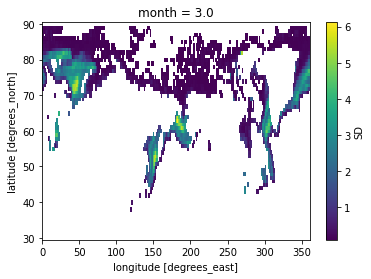

In [92]:
sigma_obs_03_xr.isel(dataset=0).where(sigma_obs_03_xr.isel(dataset=0)>0.1).plot()

In [6]:
model_names_center = ['   CanESM2', 
                      '     CESM1', 
                      ' CSIRO MK36',
                      '  GFDL CM3',
                      'GFDL ESM2M', 
                      '  MPI ESM1']

titles_datasets = ['Minimum '+r'$\sigma_{obs}$'+' and '+r'$\mu_{obs}$', 'Maximum '+r'$\sigma_{obs}$'+' and '+r'$\mu_{obs}$', '     All '+r'$\sigma_{obs}$'+' and '+r'$\mu_{obs}$']

# Add in pink and light blue for only one of the metrics classify as inconsistent

In [96]:
# run the inconsistent calculations
min_SD = calc_inconsistent_max_min_obs('SD', sigma_obs_03_xr.min('dataset'),  sigma_obs_09_xr.min('dataset'), 0)
min_mean = calc_inconsistent_max_min_obs('mean', mu_obs_03_xr.min('dataset'),  mu_obs_09_xr.min('dataset'), 0)

max_SD = calc_inconsistent_max_min_obs('SD', sigma_obs_03_xr.max('dataset'),  sigma_obs_09_xr.max('dataset'), 0)
max_mean = calc_inconsistent_max_min_obs('mean', mu_obs_03_xr.max('dataset'),  mu_obs_09_xr.max('dataset'), 0)

In [97]:
no_ice_list = [min_SD[2], max_SD[2], max_SD[2]] #using AND no sea ice mem and obs, above uses OR

In [98]:
#minimum
min_reds_added  = (min_SD[0] + min_mean[0].values)
min_blues_added = (min_SD[1] + min_mean[1].values)

l_red_min = min_reds_added.where(min_reds_added==1,0)
red_min   = min_reds_added.where(min_reds_added==2,0)/2

l_blue_min = min_blues_added.where(min_blues_added==1,0)
blue_min   = min_blues_added.where(min_blues_added==2,0)/2

black_min = ((l_red_min + red_min) *-1*(l_blue_min + blue_min)).where(((l_red_min + red_min) *-1*(l_blue_min + blue_min))<0,0)

#maximum 
max_reds_added  = (max_SD[0] + max_mean[0].values)
max_blues_added = (max_SD[1] + max_mean[1].values)

l_red_max = max_reds_added.where(max_reds_added==1,0)
red_max   = max_reds_added.where(max_reds_added==2,0)/2

l_blue_max = max_blues_added.where(max_blues_added==1,0)
blue_max   = max_blues_added.where(max_blues_added==2,0)/2

black_max = ((l_red_max + red_max) *-1*(l_blue_max + blue_max)).where(((l_red_max + red_max) *-1*(l_blue_max + blue_max))<0,0)

In [99]:
#blue AND blue
blue_both = xr.ufuncs.logical_and(blue_min, blue_max)

#red AND red
red_both = xr.ufuncs.logical_and(red_min, red_max)

#light blue if (blue AND light blue) OR (light blue AND blue)
l_blue_both = xr.ufuncs.logical_or(xr.ufuncs.logical_and(blue_min, l_blue_max), xr.ufuncs.logical_and(l_blue_min, blue_max))

#light red if (red AND light red) OR (light red AND red)
l_red_both = xr.ufuncs.logical_or(xr.ufuncs.logical_and(red_min, l_red_max), xr.ufuncs.logical_and(l_red_min, red_max))

### black both
#black starting with light/dark blue or red
black_start_red_blue = xr.ufuncs.logical_or(xr.ufuncs.logical_and(xr.ufuncs.logical_or(red_min, l_red_min), xr.ufuncs.logical_or(blue_max, l_blue_max)),
                                            xr.ufuncs.logical_and(xr.ufuncs.logical_or(blue_min, l_blue_min), xr.ufuncs.logical_or(red_max, l_red_max)))
#black starting with white and not white
black_start_white = xr.ufuncs.logical_and(xr.ufuncs.logical_not(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_min,l_red_min), xr.ufuncs.logical_or(blue_min, l_blue_min))),
                                          xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_max,l_red_max), xr.ufuncs.logical_or(blue_max, l_blue_max)))

#black starting with not white and white
black_start_not_white = xr.ufuncs.logical_and(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_min,l_red_min), xr.ufuncs.logical_or(blue_min, l_blue_min)),
                                              xr.ufuncs.logical_not(xr.ufuncs.logical_or(xr.ufuncs.logical_or(red_max,l_red_max), xr.ufuncs.logical_or(blue_max, l_blue_max))))

black_both = xr.ufuncs.logical_or(xr.ufuncs.logical_or(black_start_red_blue, black_start_white), black_start_not_white) 


### make lists of min, max, and both columns for the month
l_red_list    = [l_red_min, l_red_max, l_red_both]
red_list    = [red_min, red_max, red_both]
l_blue_list    = [l_blue_min, l_blue_max, l_blue_both]
blue_list    = [blue_min, blue_max, blue_both]
black_list  = [black_min, black_max, black_both]

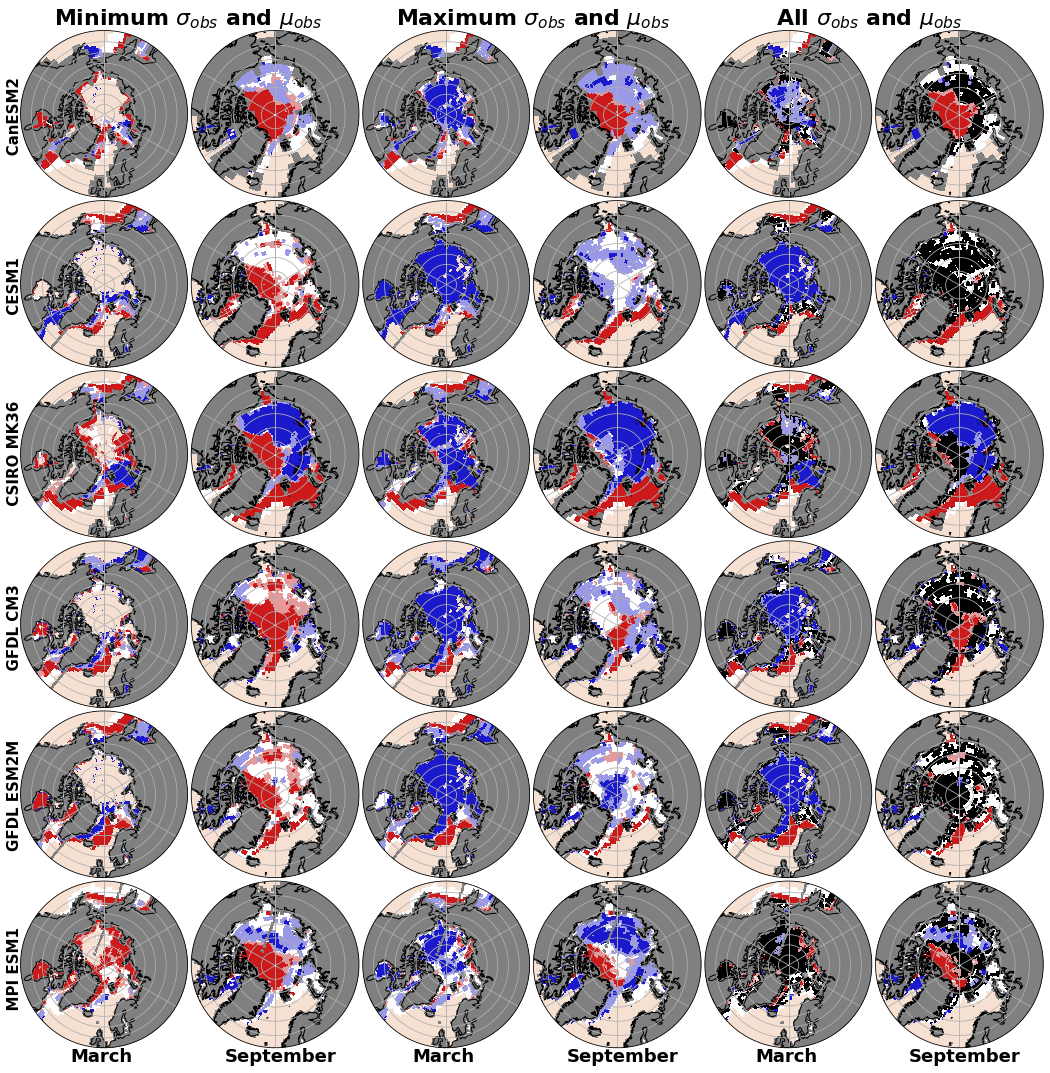

In [100]:
#plot 6x6
fig = plt.figure(figsize=[18,18])

for dataset in range(3):
    
    for model_i, model_name in enumerate(model_names):
        for month_i, month_ in enumerate([3,9]):

            i = (model_i*2) + month_i + 1
            if month_ == 3:
                lat_min = 50
            else:
                lat_min = 60

            ax = fig.add_subplot(6,6,i+(model_i*4 + dataset*2), projection = ccrs.NorthPolarStereo(central_longitude=0))
            ax.set_extent((-180,180,lat_min,90), ccrs.PlateCarree())

            #set boundary of subplots
            theta = np.linspace(0, 2*np.pi, 100) #make the plot circular
            center, radius = [0.5, 0.5], 0.5
            verts = np.vstack([np.sin(theta), np.cos(theta)]).T
            circle = mpath.Path(verts * radius + center)
            ax.set_boundary(circle, transform=ax.transAxes)
            ax.set_facecolor('1')
            
            #plot in sequence: red (too high), blue (too low), black (disagreement), baige (no sea ice), gray (land)
            #black - disagreement
            black_list[dataset].sel(model=model_name).sel(month=month_).plot(colors='0', levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')            
            #light red - too high in one metric
            l_red_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.9, 0.6, 0.6)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #red - too high
            red_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.8, 0.1, 0.1)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #light blue - too low in one metric
            l_blue_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.6, 0.6, 0.9)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #blue - too low
            blue_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.1, 0.1, 0.8)], levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #baige - no sea ice 
            no_ice_list[dataset].sel(model=model_name).sel(month=month_).plot(colors=[(0.96,0.88,0.82)], levels=[-2,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            #gray - land 
            xr.ufuncs.isnan(masks_copied[model_name]).plot(colors='0.5', levels=[1,2], add_labels=False, add_colorbar=False, transform=ccrs.PlateCarree(), extend='neither', linewidths=0.0000000001, edgecolors='face')
            
            ax.coastlines()
            ax.gridlines()

            if i == 1:    
                ax.text(0.2, 1.14, titles_datasets[dataset], fontsize=22, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
            elif i == 12:
                ax.text(0.2, 0, 'September', fontsize=18, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
            elif i == 11:
                ax.text(0.3, 0, 'March', fontsize=18, fontweight='bold', transform=ax.transAxes, va='top', ha='left');
            
            if (i+(model_i*4 + dataset*2)-1) % 6 == 0:
                ax.text(-0.08, 0.16, model_names_center[model_i], fontsize=15, fontweight='bold', transform=ax.transAxes, va='bottom', ha='left', rotation='vertical');
                

fig.subplots_adjust(top=0.91, left=0.02, hspace=0.02, wspace=-0.4);
# fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble_revisions/SIC/figures/Consistency_6x6_individual_1989_2020.pdf', bbox_inches = 'tight', pad_inches = 0)
# fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6_min_max_with_light.png', bbox_inches = 'tight', pad_inches = 0, dpi=300)

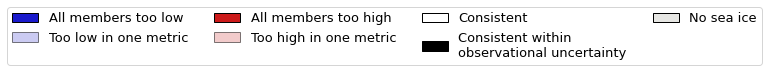

In [67]:
fig = plt.figure(figsize=[0.01,0.01])
legend_elements = [Patch(facecolor=(0.1, 0.1, 0.8), ec='0', label='All members too low'),
                   Patch(facecolor=(0.6, 0.6, 0.9), ec='0', alpha=0.5, label='Too low in one metric'),
                   Patch(facecolor=(0.8, 0.1, 0.1), ec='0', label='All members too high'),
                   Patch(facecolor=(0.9, 0.6, 0.6), ec='0', alpha=0.5, label='Too high in one metric'),
                   Patch(facecolor='1', ec='0', label='Consistent'),
                   Patch(facecolor='0', ec='0', label='Consistent within \n'+'observational uncertainty'),
                   Patch(facecolor=(0.9,0.9,0.89), ec='0', label='No sea ice')]

plt.legend(handles=legend_elements, bbox_to_anchor=(0, 0), loc='lower left', borderaxespad=0., ncol=4, fontsize=13)
plt.gca().set_axis_off()
# fig.savefig('/glade/scratch/cwpowell/Synthetic_ensemble/SIC/figures/Resampled_figures_SIC_Consistency_6x6_legend.pdf', bbox_inches = 'tight', pad_inches = 0)

In [46]:
no_ice_list[1].sel(model='CanESM2').sel(month=3)

<xarray.DataArray 'SD' (lat: 61, lon: 361)>
array([[-2., -2., -2., ..., -2., -2., -2.],
       [-2., -2., -2., ..., -2., -2., -2.],
       [-2., -2., -2., ..., -2., -2., -2.],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0 360.0
  * lat      (lat) float64 29.9 30.9 31.9 32.9 33.9 ... 85.9 86.9 87.9 88.9 89.9
    month    int64 3
    model    <U10 'CanESM2'